In [ ]:
# shape of test data
X_test.shape

In [ ]:
%pip install imblearn

# Import Section

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score



2023-11-03 11:34:26.270802: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 11:34:26.318201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 11:34:27.146696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Loading Dataset

In [2]:
FILE_PATH_TRAINING = "../dataset/UNSW_NB15_training-set.csv"
FILE_PATH_TESTING = "../dataset/UNSW_NB15_testing-set.csv"

df_training =   pd.read_csv(FILE_PATH_TRAINING)
df_testing =    pd.read_csv(FILE_PATH_TESTING)

In [ ]:
df_training.shape, df_testing.shape

In [ ]:
print(*df_training.columns, sep="\n")

In [ ]:
for col in df_training.columns:
    if 50 >=df_training[col].nunique() :
        print(col, df_training[col].nunique())

# EDA

In [ ]:
df_training.info()

In [ ]:
df_training.describe()
# before log transformation

In [ ]:
df_training.describe()
# After log transformation

In [ ]:
def plot_normal_distribution(df):
    for column in df.columns:
        sns.displot(df[column])
        plt.show()
        
plot_normal_distribution(df_training)

# Data Preprocessing

## Removing columns

In [3]:
columns_to_remove = ['id','proto','state','service','attack_cat']
df_training.drop(columns_to_remove, axis=1, inplace=True)
df_testing.drop(columns_to_remove, axis=1,inplace=True)


### Remove columns for multi-class classification

In [ ]:
columns_to_remove = ['id','proto','state','service','label']
df_training.drop(columns_to_remove, axis=1, inplace=True)
df_testing.drop(columns_to_remove, axis=1,inplace=True)

## Log Modification

In [4]:
for column in df_training.columns:
    if column !='label' and df_training[column].nunique() > 50:
        df_training[column] = np.log(df_training[column]+1)
        df_testing[column] = np.log(df_testing[column]+1)
    

## Data Standardization

In [5]:
standard_scaler = StandardScaler()

for column in df_training.columns:
    if column != 'label' and column != 'attack_cat':
        standard_scaler.fit(df_training[column].values.reshape(-1,1))
        df_training[column] = standard_scaler.transform(df_training[column].values.reshape(-1,1))
        df_testing[column] = standard_scaler.transform(df_testing[column].values.reshape(-1,1))

In [ ]:
# after standardization
df_training.describe()

# Train Test Split

## Splitting

In [6]:
X_train = df_training.drop('label', axis=1)
y_train = df_training['label']

X_test = df_testing.drop('label', axis=1)
y_test = df_testing['label']



### Spliting for multiclass classification

In [ ]:
X_train = df_training.drop('attack_cat', axis=1)
y_train = df_training['attack_cat']

X_test = df_testing.drop('attack_cat', axis=1)
y_test = df_testing['attack_cat']

### Encoding for multiclass classification

In [ ]:
# encode attack_cat using label encoder
from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y_train = labelencoder_y.fit_transform(y_train)
y_test = labelencoder_y.transform(y_test)


# y_train = pd.get_dummies(y_train)
# y_test = pd.get_dummies(y_test)


In [10]:
f={}
for i in range(len(y_train)):
    if y_train[i] not in f:
        f[y_train[i]]=1
    else:
        f[y_train[i]]+=1
print(f)

{0: 56000, 1: 119341}


In [9]:
# Calculate class weights to handle class imbalance
class_counts = np.bincount(y_train)
class_weights = dict(enumerate((max(class_counts) / class_counts).astype(float)))
print(class_weights)


{0: 2.131089285714286, 1: 1.0}


### Random Oversampling for multiclass classification

In [31]:
from imblearn.over_sampling import RandomOverSampler

# Create a RandomOverSampler object
oversampler = RandomOverSampler()

# Fit and transform the data
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)


In [ ]:
X_train, y_train = X_train_oversampled, y_train_oversampled

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

## Validation split

In [11]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [35]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((112217, 39), (112217,), (28055, 39), (28055,))

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Fit a Random Forest model using class weights
rf = RandomForestClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=False)
rf.fit(X_train, y_train)



[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    1.8s finished


RandomForestClassifier(criterion='entropy', n_jobs=50, random_state=42,
                       verbose=1)

In [13]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8720667541174756


[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           0       0.97      0.73      0.84     37000
           1       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332



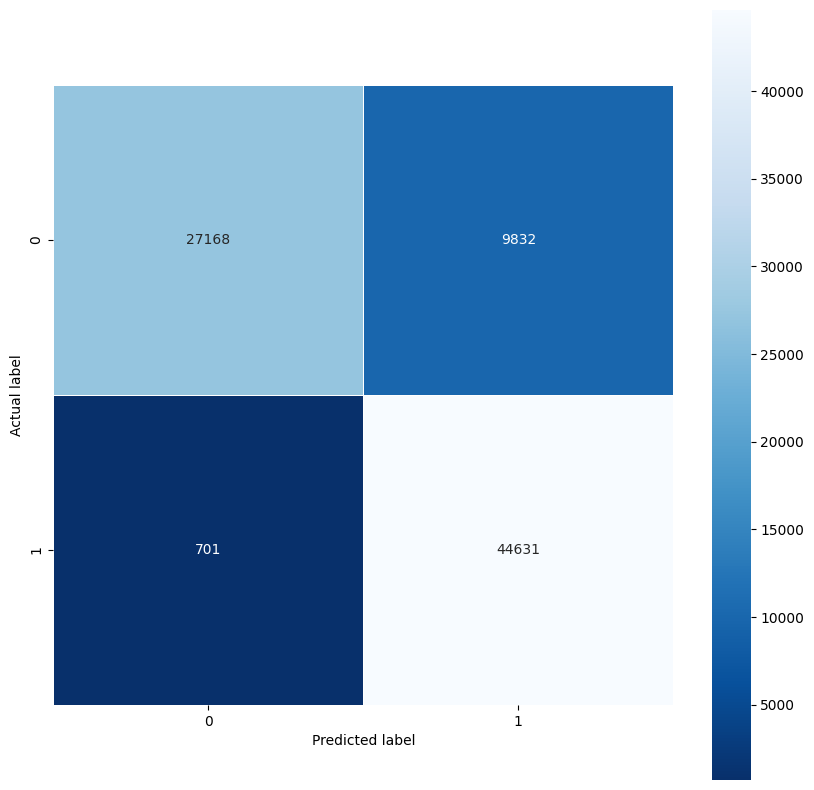

In [14]:
print(classification_report(y_test, y_pred))
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');


In [43]:

# Get feature importances
feature_importances = rf.feature_importances_

In [44]:
feature_importances

array([2.53301689e-02, 9.38280637e-03, 1.49808360e-02, 4.24626549e-02,
       3.48146291e-02, 4.63444468e-02, 1.47269875e-01, 5.25307784e-02,
       4.84680088e-02, 6.67049909e-02, 1.18438815e-02, 8.80576954e-03,
       2.82458444e-02, 3.22511137e-02, 1.40812990e-02, 1.09714324e-02,
       8.03620835e-03, 8.42620438e-03, 8.05522186e-03, 2.33623927e-04,
       2.57836069e-02, 2.18951245e-02, 2.04871041e-02, 4.02369029e-02,
       3.05743252e-02, 1.66711928e-03, 1.58309908e-03, 2.61853875e-02,
       1.03636426e-01, 9.82160136e-03, 8.54517308e-03, 1.94236262e-02,
       2.60861343e-02, 7.61478011e-05, 7.49643097e-05, 1.84389046e-03,
       8.93104287e-03, 2.86061618e-02, 5.30236777e-03])

In [15]:
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances}).sort_values('importance', ascending = False)


NameError: name 'feature_importances' is not defined

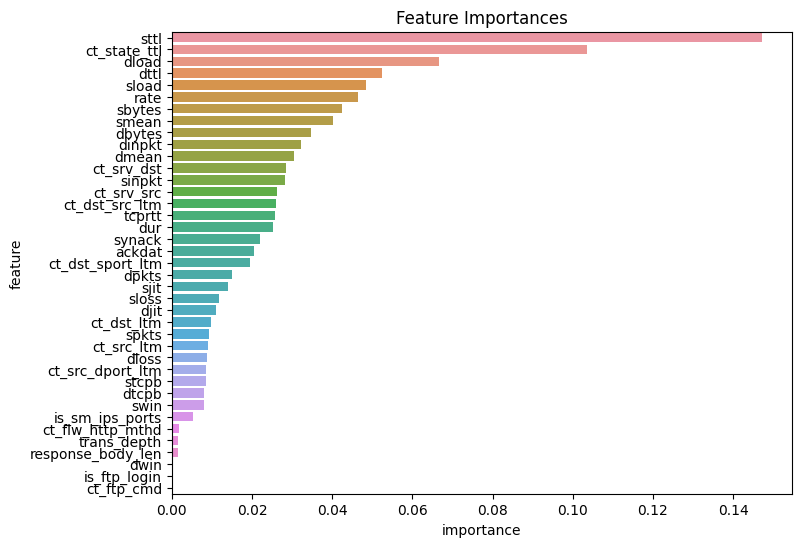

In [61]:
# plot feature importances
plt.figure(figsize = (8, 6))
sns.barplot(x = 'importance', y = 'feature', data = feature_importances)
plt.title('Feature Importances')
plt.show()


In [54]:
# select features with importance greater than 0.01
selected_features = feature_importances[feature_importances['importance'] > 0.05]['feature'].values


In [55]:
# total number of features selected vs total number of features
len(selected_features), X_train.shape[1]

(4, 39)

In [56]:
# new training and testing data with selected features
X_train = X_train[selected_features]
X_test = X_test[selected_features]
X_val = X_val[selected_features]

In [ ]:
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

# Model ANN

## Model

In [16]:
def get_model_ann():
  model = Sequential()
  model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def get_model_ann_multiclass():
  model = Sequential()
  model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# model_ann = get_model_ann()  
model_ann = get_model_ann()

2023-11-02 07:18:27.878406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-11-02 07:18:27.879351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 220 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:af:00.0, compute capability: 7.5
2023-11-02 07:18:27.880167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 5099 MB memory:  -> device: 2, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


## Train

In [17]:
history_ann = model_ann.fit(X_train, y_train, epochs=50, batch_size=256, verbose=1, validation_data=(X_val, y_val))


NameError: name 'X_val' is not defined

## Predict

In [15]:
# load model
model_ann = load_model('models/saved_models/model_ann_20231103-112820_0.887.keras')

### Binary prediction

In [16]:
y_prediction_ann = model_ann.predict(X_test)


ValueError: in user code:

    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 42), found shape=(None, 39)


In [19]:
threshold = 0.5
y_prediction_ann = np.where(y_prediction_ann > threshold, 1, 0)

In [20]:
accuracyScore_ann = accuracy_score(y_test, y_prediction_ann)
print("ANN Accuracy: ", accuracyScore_ann)

ANN Accuracy:  0.8532283923626294


In [21]:
loss, accuracy = model_ann.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))

2573/2573 [==============================] - 21s 8ms/step - loss: 0.2809 - accuracy: 0.8532
Accuracy: 85.322839
Loss: 28.093141


### Multi ClassPredicition


In [ ]:
y_prediction_ann_multiclass = np.argmax(y_prediction_ann, axis=1)

In [ ]:
# calculate accuracy
accuracyScore_ann = accuracy_score(y_test, y_prediction_ann_multiclass)
print("ANN Accuracy with multiclass: ", accuracyScore_ann)

### Plot graph of probability of each class

In [22]:
def plot_probabilities(y_prediction_array, true_label,predicted_label=None):
  if predicted_label is None:
    predicted_label = np.argmax(y_prediction_array)
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), y_prediction_array, color="#777777")
  plt.ylim([0, 1])
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

  plt.show()


for i in range(56, 60):
  plot_probabilities(y_prediction_ann[i], y_test[i], y_prediction_ann_multiclass[i])

NameError: name 'y_prediction_ann_multiclass' is not defined

In [23]:
def plot_confusion_matrix(y_test, y_prediction, title):
    cm = confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(y_test, y_prediction_ann_multiclass, "ANN Confusion Matrix")

NameError: name 'y_prediction_ann_multiclass' is not defined

### Predict for multi-class classification

In [ ]:
# save model with time and accuracy
import datetime
model_ann.save('model_ann_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_'+str(accuracyScore_ann)[0:5]+'.h5')

## Confusion Matrix

In [24]:
print(classification_report(y_test, y_prediction_ann))

              precision    recall  f1-score   support

           0       0.98      0.69      0.81     37000
           1       0.80      0.99      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.89      0.84      0.84     82332
weighted avg       0.88      0.85      0.85     82332



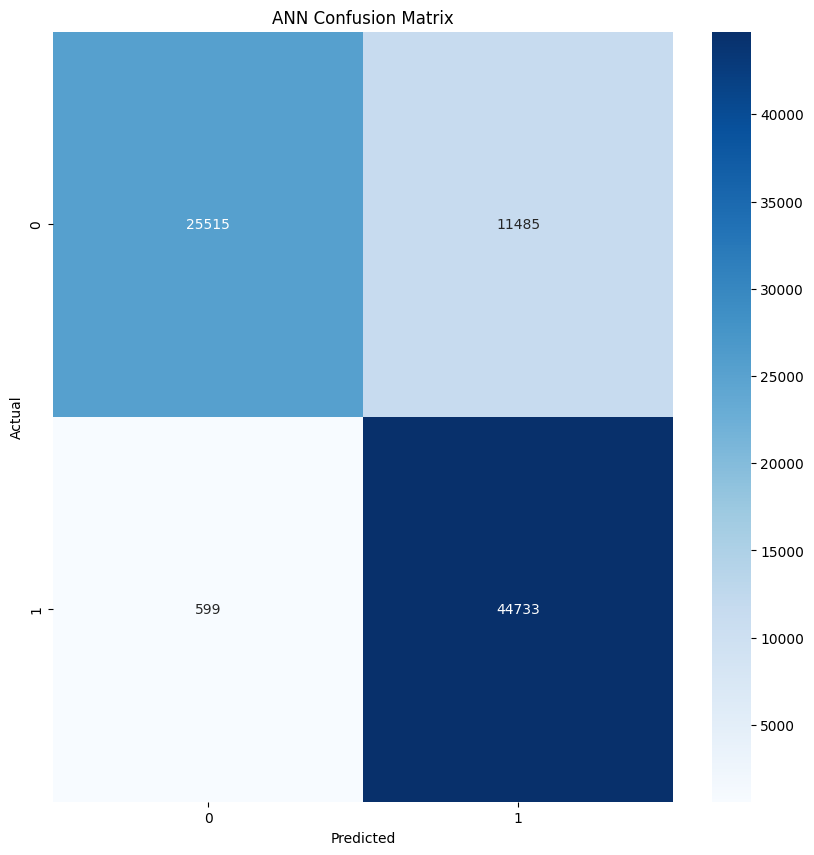

In [25]:
## give confusion matrix
cm_ann = confusion_matrix(y_test, y_prediction_ann)
##  plot it
plt.figure(figsize=(10,10))
plt.title('ANN Confusion Matrix')
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Roc Curve

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction_ann)
roc_auc = auc(fpr, tpr)



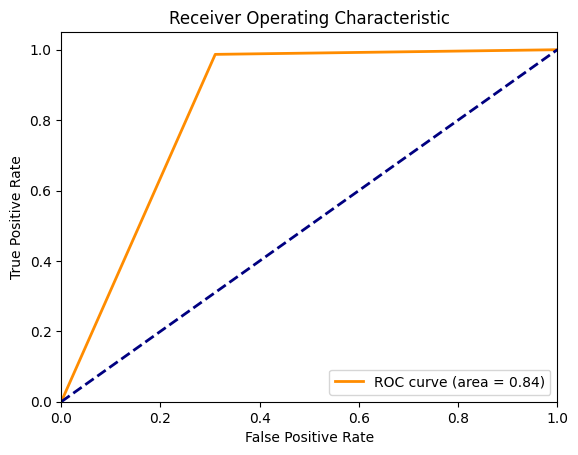

AUC Score: 0.8594032900808688


In [27]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred)
print("AUC Score:", auc_score)


# Random Forest

In [62]:

rf = RandomForestClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=True)

rf.fit(X_train, y_train)

[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    0.9s finished


RandomForestClassifier(criterion='entropy', n_jobs=50, random_state=42,
                       verbose=1, warm_start=True)

In [63]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.794891415245591


[Parallel(n_jobs=50)]: Using backend ThreadingBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done 100 out of 100 | elapsed:    0.1s finished


# XGBoost

In [ ]:
# write code for xgboost
xgb = XGBClassifier(n_estimators=100, n_jobs=50, random_state=42, verbose=1, criterion='entropy',warm_start=True)
xgb.fit(X_train, y_train)


In [ ]:
#predict
y_pred = xgb.predict(X_test)


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# LSTM

In [65]:
def get_model_lstm():
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(25, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(10))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model_lstm = get_model_lstm()


2023-11-02 07:02:12.260809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5329 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:3b:00.0, compute capability: 7.5
2023-11-02 07:02:12.262956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 220 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:af:00.0, compute capability: 7.5
2023-11-02 07:02:12.264834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 5099 MB memory:  -> device: 2, name: Tesla T4, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [66]:
# reshape data for LSTM
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))


In [1]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

NameError: name 'X_train' is not defined

In [68]:
# fit model
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=1024, verbose=1, validation_data=(X_val, y_val))

Epoch 1/100


2023-11-02 07:02:19.420077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-02 07:02:19.723367: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1f0c013090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 07:02:19.723443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-11-02 07:02:19.723467: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2023-11-02 07:02:19.723482: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2023-11-02 07:02:19.731008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 07:02:19.895518: I ./tensorflow/compiler/jit/device_compiler.h:186] Compi

110/110 [==============================] - 10s 32ms/step - loss: 0.4840 - accuracy: 0.8814 - val_loss: 0.3221 - val_accuracy: 0.9219
Epoch 2/100
110/110 [==============================] - 3s 23ms/step - loss: 0.2797 - accuracy: 0.9223 - val_loss: 0.2557 - val_accuracy: 0.9219
Epoch 3/100
110/110 [==============================] - 3s 24ms/step - loss: 0.2530 - accuracy: 0.9223 - val_loss: 0.2354 - val_accuracy: 0.9219
Epoch 4/100
110/110 [==============================] - 3s 23ms/step - loss: 0.2321 - accuracy: 0.9223 - val_loss: 0.2223 - val_accuracy: 0.9219
Epoch 5/100
110/110 [==============================] - 3s 24ms/step - loss: 0.2253 - accuracy: 0.9224 - val_loss: 0.2198 - val_accuracy: 0.9219
Epoch 6/100
110/110 [==============================] - 3s 24ms/step - loss: 0.2233 - accuracy: 0.9223 - val_loss: 0.2178 - val_accuracy: 0.9219
Epoch 7/100
110/110 [==============================] - 3s 25ms/step - loss: 0.2209 - accuracy: 0.9223 - val_loss: 0.2177 - val_accuracy: 0.9219
Epo

In [69]:
# evaluate model on test data
y_prediction_lstm = model_lstm.predict(X_test)

threshold = 0.5

y_prediction_lstm = np.where(y_prediction_lstm > threshold, 1, 0)

accuracyScore_lstm = accuracy_score(y_test, y_prediction_lstm)

print("LSTM Accuracy: ", accuracyScore_lstm)



2573/2573 [==============================] - 19s 7ms/step
LSTM Accuracy:  0.7663241509983967


In [70]:
# save model with time and accuracy
import datetime
model_lstm.save('model_lstm_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_'+str(accuracyScore_lstm)[0:5]+'.h5')

/home/sukhmeet/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
# evaluate model on test data
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy_lstm*100))
print('Loss: %f' % (loss_lstm*100))

   6/2573 [..............................] - ETA: 28s - loss: 1.4393 - accuracy: 0.0417 

2573/2573 [==============================] - 28s 11ms/step - loss: 0.4596 - accuracy: 0.7663
Accuracy: 76.632416
Loss: 45.959011


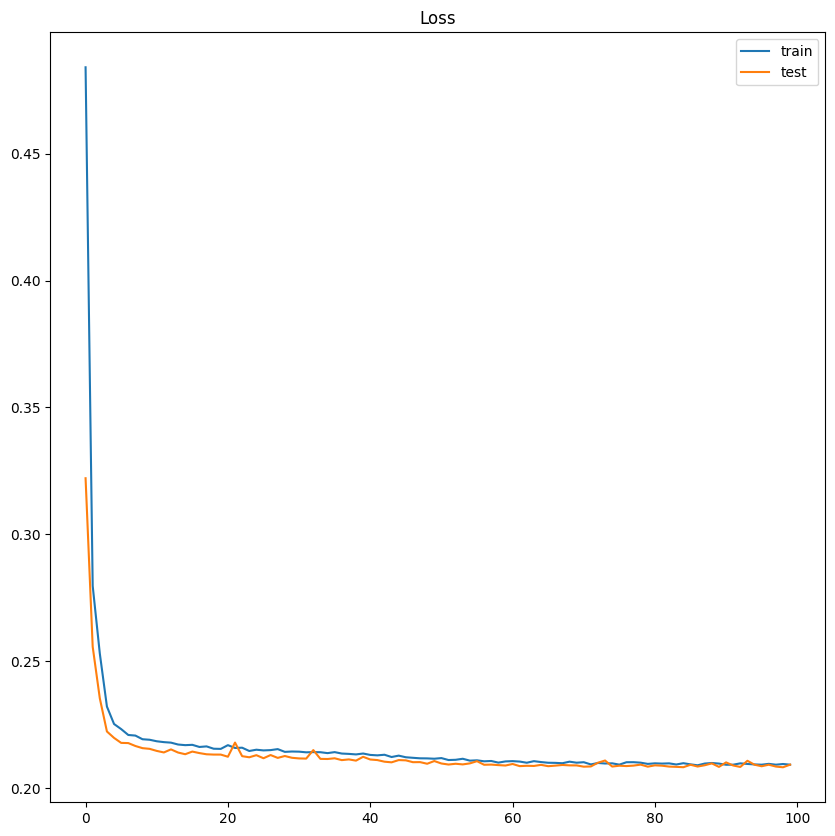

In [72]:
# plot loss during training
plt.figure(figsize=(10, 10))
plt.title('Loss')
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()


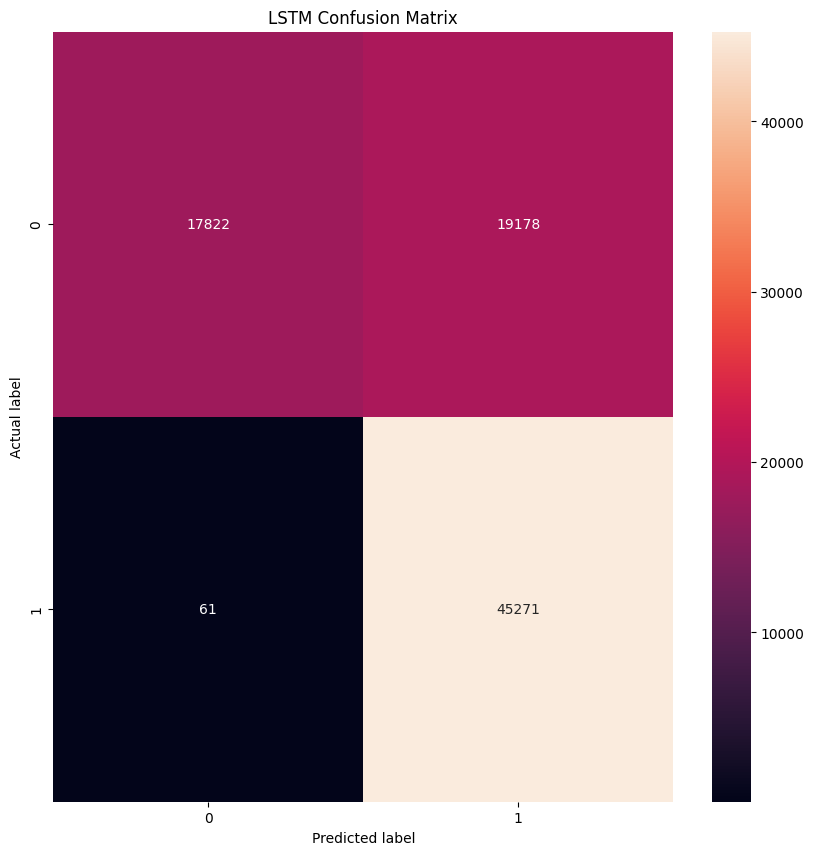

In [75]:
# confusion matrix
def plot_confusion_matrix(y_test, y_prediction, title):
    cm = confusion_matrix(y_test, y_prediction)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

plot_confusion_matrix(y_test, y_prediction_lstm, "LSTM Confusion Matrix")
